In [54]:
import os 
os.environ['CUDA_VISIBLE_DEVICES']='-1'

In [203]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow import keras

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import pickle

Frame the Problem and Look at the Big Picture
=====================================

1. **Define the objective in business terms:** We have been hired by Magic Films for their new streaming service which provides access to a wide variety of movies. 
2. **How will your solution be used?** They want to eventually know what movies should be displayed and promoted on the homepage to attract users based on written reviews from viewers as well as what movies to remove from the website to save money on licensing fees.
3. **What solutions are in place?** For certain businesses such as the restaurant business, they try and identify certain keywords in reviews to find out what they are doing well and their customers like and what they can improve on.
4. **How should you frame this problem?** This is a supervised binary classification problem. Based on words and how they are used in a review we want to determine whether the review was `Positive` or `Negative`.
5. **How should performance be measured? Is the performance measure aligned with the business objective?** Because we are not to identify as many positives as we can by risking false positives and we are not trying to identify all the negatives we can, we believe we should use F1 score to find a middle ground. We want to reduce false positives and false negatives as equally as possible.
6. **What would be the minimum performance needed to reach the business objective?** We would like to get our score as close to 1.0 as possible. A goal is to get at least .85 or better.
7. **What are comparable problems? Can you reuse experience or tools?** We have had multi-classification experience with the MNIST data set for trying to decide what a number a written digit or what article of clothing something is. More importantly, we previously created a binary-classification model that would try to predict whether there would be an early spring or not. We would not be able to directly reuse this model in particular because we are trying to identify words within a review to determine if the review was positive or not.
8. **Is human expertise available?** We do not have anyone readily available but we are advised on the Readme to contact Andrew Maas, the organizer of the dataset, with any questions. We can also try and contact the user who uploaded the dataset to Kaggle.
9. **How would you solve the problem manually?** The manual approach would to be to parse up the reviews and try and filter out words with negative or positive connotations in order to decide whether a review is positive or negative. This could be a problem with sarcastic reviews and reviews with spelling errors or slang.
10. **List the assumptions you (or others) have made so far. Verify assumptions if possible.** We are assuming that the data set is all primarily english and has no spelling mistakes or errors in the reviews.

In [56]:
# Functions for loading and splitting data
def load_data(data):
    """Loads a dataset"""
    return pd.read_csv(data)


def split_labels(data, label_feature):
    """
    Split the given column of the data, returning the full data set (without that
    feature) and the split off feature.
    """
    return data.drop(columns=label_feature), data[label_feature]

Get the Data
==========

1. **List the data you need and how much you need:** We have a dataset of IMDB movie reviews containing a combniation of positive and negative reviews for movies.
2. **Find and document where you can get that data:** We got the data from: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews?resource=download
3. **Get access authorizations**: No authorization needed, the data is free to access on Kaggle.
4. **Create a workspace**: This notebook.
5. **Get the data**: Downloaded from Kaggle.
6. **Convert the data to a format you can easily manipulate**: Already in CSV files so easy to use.
7. **Ensure sensitive information is deleted or protected**: Data contains no sensitive information.
8. **Check the size and type of data (time series, geographical, …)**: This categorical data set contains reviews written in text as well as a binary attribute indicating whether the review was positive or not. It contains 50,000 values.

In [57]:
data = load_data('imdb_data.csv')

In [58]:
data.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [59]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


Review
======

In [60]:
data['review'].describe()

count                                                 50000
unique                                                49582
top       Loved today's show!!! It was a variety and not...
freq                                                      5
Name: review, dtype: object

`review` is a text object containing a written review of a certain film. There are 50000 of these reviews but only 49582 are unique. This will be the main feature that we will try and derive meaning and sentiment from as well as create new features.

Sentiment
=========

In [61]:
data['sentiment'].describe()

count        50000
unique           2
top       positive
freq         25000
Name: sentiment, dtype: object

`sentiment` is our <b>target feature</b> and is a binary categorical variable. This is the label that indicates whether a review is a positive one or negative. A review is labeled simply as `positive` or `negative`.

In [62]:
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42, shuffle=True, stratify=data['sentiment'])
train_set, valid_set = train_test_split(train_set, test_size=0.1, random_state=42, shuffle=True, stratify=train_set['sentiment'])
X_train, y_train = split_labels(train_set, 'sentiment')
X_test, y_test = split_labels(test_set, 'sentiment')
X_valid, y_valid = split_labels(valid_set, 'sentiment')

In [63]:
positives = train_set[train_set['sentiment']=='positive'].reset_index()
negatives = train_set[train_set['sentiment']=='negative'].reset_index()
len(positives), len(negatives)

(18000, 18000)

About half of the reviews in the training set are positive and the other half is negative, so both types are about equally represented. And it is also nice to know there are not any missing values in the dataset, which is important with just two features.

In [64]:
positives.head(10)

,index,review,sentiment
0,33890,This is an excellent stand-up DVD! Eddie Izzar...,positive
1,35186,This movie has always been a favorite of mine ...,positive
2,41267,"This is an excellent, fast paced thriller by W...",positive
3,21302,I think this movie is my favorite movie. I am ...,positive
4,13974,Best Years of Our Lives is a film that slipped...,positive
5,24506,It's 1913. A studio prop boy spies the actress...,positive
6,25859,"""Showtime"" is a funny film starring funnymen R...",positive
7,32515,This is a great TV miniseries of a classic nov...,positive
8,26441,This is one of my favorite family movies. Love...,positive
9,34065,"If you think about it, it's nearly unbelievabl...",positive


Below is a positive review, giving us an idea of what this kind of review will look like.

In [65]:
positives['review'][42]

"In Iran, the Islamic Revolution has shaped all parts of life, including everyday things. But people still go on living their lives, generally just doing the things you'd expect, like go to soccer matches to cheer on the national team as it's in the running to qualify for the World Cup. Except women aren't allowed to go to the soccer stadium to watch the game.<br /><br />A frequently funny little film follows the small group of women that were caught sneaking into the soccer stadium and the little group of bored soldiers assigned to guard them in a holding pen just outside the stadium. The absurdity of the situation, the simple wish of these women to cheer on the team (nothing subversive there), and little human touches about the lives of everyone adds up to quite a fine comment on humanity versus the ideology.<br /><br />Amateurish acting, good script and dialogue, a really enjoyable film. Bend It Like Beckham, sort of - a warm heart and a joy in the daily interests and pleasures of p

Below is a negative review, giving us an idea of what this kind of review will look like.
It should be noted that there appear to be `HTML` elements peppered in some of the positive and negative reviews. In this example we see a `<br />` tag.

We can remove the html with a regular expression substitution

In [66]:
import re as re
def remove_tags(string):
    result = re.sub('<.*?>',' ', string)
    return result

positives['review'] = positives['review'].apply(lambda review : remove_tags(review))
negatives['review'] = negatives['review'].apply(lambda review : remove_tags(review))

positives['review'][42]

"In Iran, the Islamic Revolution has shaped all parts of life, including everyday things. But people still go on living their lives, generally just doing the things you'd expect, like go to soccer matches to cheer on the national team as it's in the running to qualify for the World Cup. Except women aren't allowed to go to the soccer stadium to watch the game.  A frequently funny little film follows the small group of women that were caught sneaking into the soccer stadium and the little group of bored soldiers assigned to guard them in a holding pen just outside the stadium. The absurdity of the situation, the simple wish of these women to cheer on the team (nothing subversive there), and little human touches about the lives of everyone adds up to quite a fine comment on humanity versus the ideology.  Amateurish acting, good script and dialogue, a really enjoyable film. Bend It Like Beckham, sort of - a warm heart and a joy in the daily interests and pleasures of people."

In [67]:
negatives['review'][13]

"This is not great cinema. The film is cliche ridden and in many places it is a copy of the original Carrie. The parallels with the original film are striking but with an added improbability about the telekenetic powers being congenital.  I can't say that I disliked the film because it at least passed a couple of hours ... but these were passed as one would read an undemanding book on a long train journey. That book would not be great literature but would absorb one for a while and be forgotten soon afterwards in that it would blend in with the numerous other cliche ridden books. Likewise the film was okay whilst it lasted but is perhaps forgettable. At least I think it is. I cant remember much about it now!!"

To begin breaking down reviews and what words might entail a negative or positive review we might want to try and see what words are most popularly used...

In [200]:
pd.Series(' '.join(positives['review']).lower().split()).value_counts().head(8)

the    239956
and    123672
a      116261
of     108634
to      93468
is      78437
in      69447
i       50643
dtype: int64

But as expected, this approach will result in finding a lot of the words will be prepositions, determiners, conjuctions or very basic words found in speech. What might be more helpful is identifying key phrases, or less than the most common words

In [69]:
pd.Series(' '.join(positives['review']).lower().split()).value_counts()[400:500]

completely    937
rest          934
start         934
friends       933
episode       933
             ... 
drama         743
white         742
directed      741
course,       739
including     739
Length: 100, dtype: int64

In [70]:
pd.Series(' '.join(negatives['review']).lower().split()).value_counts()[400:500]

me.            994
is,            994
bad,           992
performance    991
line           986
              ... 
bunch          794
running        789
cheap          789
writing        785
finally        784
Length: 100, dtype: int64

If we get to words used frequently but less than the most common, we see ones that may be more telling like bad cheap writing

We could try creating a new feature such as review length and see if there is any interesting patterns for negative and postitive review lengths. This may not be extremely helpful because we want to know the sentiment of a review based on its contents but with 2 features creating new ones could be useful. But we will try and create many new features by trying to implement `Bag of Words` eventuallly so it probably won't be important.

In [71]:
positives['review_len'] = positives['review'].str.len()
len(positives['review'][0]), positives['review_len'][0]

(704, 704)

In [72]:
negatives['review_len'] = negatives['review'].str.len()
len(negatives['review'][0]), negatives['review_len'][0]

(1537, 1537)

In [73]:
positives.describe()

,index,review_len
count,18000.000000,18000.000000
mean,24994.566611,1302.842056
std,14364.484819,1009.492811
min,0.000000,65.000000
25%,12564.750000,684.000000
50%,24976.500000,954.000000
75%,37433.250000,1587.000000
max,49992.000000,13604.000000


In [74]:
negatives.describe()

,index,review_len
count,18000.000000,18000.000000
mean,24800.754222,1279.153778
std,14397.278761,938.617424
min,3.000000,41.000000
25%,12352.500000,697.000000
50%,24722.500000,958.000000
75%,37151.250000,1551.000000
max,49999.000000,8729.000000


Unfortunately there does not seem like any apparent major differences between the two, but it looks like positive reviews are longer on average.

<AxesSubplot:>

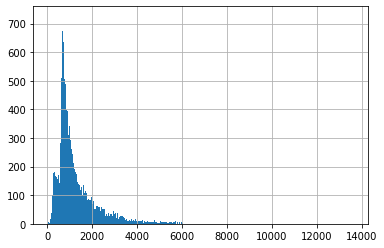

In [75]:
lengths = pd.concat([positives, negatives], axis=0)['review_len']
lengths.hist(bins=1000)

This could be improved with a log transformation. Also its seems that someone wrote a particularly lengthy review.

<AxesSubplot:>

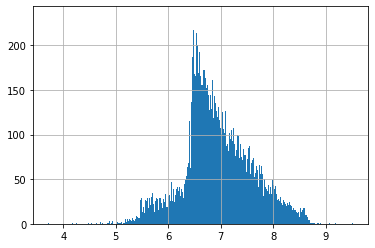

In [76]:
np.log(lengths).hist(bins=1000)

This could be a helpful metric but what we truly want is a way to detect the sentiment in reviews based off processing the words in them instead of length

Prepare the Data
====
1. **Data cleaning:** Fix/remove outliers (optional); We might possibly have to remove really long reviews? But that might not be necessary for evaluating sentiment.
2. **Feature selection** (optional): Drop attributes that provide no useful information for the task
3. **Feature engineering, where appropriate:** Discretize continuous features; Decompose features (categorical, date/time, ...), Add promising transformations of features (log(𝑥𝑥), √𝑥𝑥, 𝑥𝑥2, ...); Aggregate features into promising new features
4. **Feature scaling:** standardize or normalize features

Bag of Words
===========
In order to solve our problem of having few features we are going to try and implement a Bag of Words approach. This will help our number of features grow exponentially, and we will do this as we prepare our data.

In [77]:
vectorizer = CountVectorizer(min_df=10, max_df=6000, lowercase=True, stop_words='english')
vectorizer.fit(X_train['review'])
X_train_vectorized = vectorizer.transform(X_train['review'])

This makes a sparse matrix where each column is a specific word, each row is a review, and each entry has a 1 if the review contains that word. Similar concept to oneHot encoding but for text processing

In [78]:
X_train_vectorized.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [79]:
# Trying some classifiers on the vectorized data
for clf_name, classifier in zip(['SGD', 'Log_Reg'],[SGDClassifier(), LogisticRegression(max_iter=200)]):
    scores = cross_val_score(classifier, X_train_vectorized, y_train, cv=3, scoring='accuracy')
    print('Accuracy for {}: {}'.format(clf_name, np.mean(scores)))

Accuracy for SGD: 0.8541666666666666
Accuracy for Log_Reg: 0.8669444444444444


In [201]:
pd.Series(' '.join(positives['review']).lower().split()).value_counts()[400:420]

completely    937
rest          934
start         934
friends       933
episode       933
course        928
absolutely    925
finally       924
death         923
kids          923
mind          919
lives         914
idea          911
sometimes     909
moments       909
wants         907
felt          905
script        903
book          903
works         900
dtype: int64

We might expect our bag of words to look something like this.

With SKlearn
============

In [135]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train_set['review'])
X_train_counts.shape

(36000, 88840)

In [136]:
count_vect.vocabulary_.get(u'algorithm')

3101

In [137]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(36000, 88840)

In [138]:
y_train_int = np.where(y_train == 'positive', 1, 0)
y_test_int = np.where(y_test == 'positive', 1, 0)
y_valid_int = np.where(y_valid == 'positive', 1, 0)

In [139]:
class RemoveHTMLTransformer(BaseEstimator, TransformerMixin):
    """
    Transformer class that removes HTML tags from strings
    """
    def __init__(self):
        super().__init__()
    
    def fit(self, X, y=None, **kwargs):
        return self

    def transform(self, X):
        X.apply(lambda review : remove_tags(review))
        return X

    def remove_tags(string):
        result = re.sub('<.*?>',' ', string)
        return result

In [140]:
html_trans = RemoveHTMLTransformer()
html_trans.transform(train_set['review'])

24839    The movie starts off as we see a footage of a ...
33890    This is an excellent stand-up DVD! Eddie Izzar...
4692     Though I've yet to review the movie in about t...
34202    As a big fan of David Mamet's films and plays,...
29985    This move is bad on so many levels I don't eve...
                               ...                        
17522    Despite being quite far removed from my expect...
23897    Holy crap this movie was bad. I watched it jus...
43410    This movie is horrible. Everything in it has b...
24457    Sorry, I don't have much time to write. I am n...
15389    I really wanted to like this movie, but ended ...
Name: review, Length: 36000, dtype: object

In [157]:
text_clf = Pipeline([
    ('HTML_remover', RemoveHTMLTransformer()),
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                           alpha=1e-3, random_state=42,
                           max_iter=5, tol=None)),
])

text_clf.fit(X_train['review'], y_train_int)

predicted = text_clf.predict(X_valid['review'])
np.mean(predicted == y_valid_int)

0.84125

<AxesSubplot:>

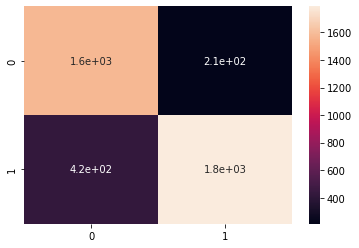

In [158]:
cm = confusion_matrix(predicted, y_valid_int)
sns.heatmap(cm, annot=True)

In [142]:
text_clf.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'HTML_remover', 'vect', 'tfidf', 'clf', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'clf__alpha', 'clf__average', 'clf__class_weight', 'clf__early_stopping', 'clf__epsilon', 'clf__eta0', 'clf__fit_intercept', 'clf__l1_ratio', 'clf__learning_rate', 'clf__loss', 'clf__max_iter', 'clf__n_iter_no_change', 'clf__n_jobs', 'clf__penalty', 'clf__power_t', 'clf__random_state', 'clf__shuffle', 'clf__tol', 'clf__validation_fraction', 'clf__verbose', 'clf__warm_start'])

In [145]:
text_param_grid = [{
    'tfidf__norm':['l1', 'l2'],
    'tfidf__sublinear_tf':[True, False],
    'clf__alpha': np.linspace(1e-6, 1e-4, 5),
    'vect__stop_words':[None, 'english'],
    'vect__max_df':[.75, 1.0],
}]
sgd_search = GridSearchCV(
    text_clf, text_param_grid,
    cv=5, scoring='f1',
    n_jobs=-1
)
sgd_search.fit(X_train['review'], y_train_int)
sgd_search.best_params_, sgd_search.best_score_

({'clf__alpha': 5.05e-05,
  'tfidf__norm': 'l2',
  'tfidf__sublinear_tf': True,
  'vect__max_df': 1.0,
  'vect__stop_words': None},
 0.8998417274351201)

We got almost 90 percent accuracy on the validation set here this might be the best model to use.

In [146]:
rfc_clf = Pipeline([
    ('HTML_remover', RemoveHTMLTransformer()),
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('rfc', RandomForestClassifier())
])

rfc_clf.fit(X_train['review'], y_train_int)

predicted = rfc_clf.predict(X_valid['review'])
np.mean(predicted == y_valid_int)

0.839

<AxesSubplot:>

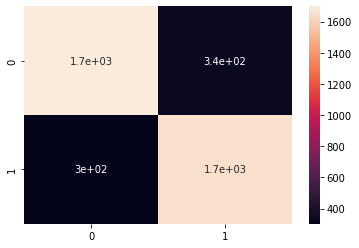

In [156]:
cm = confusion_matrix(predicted, y_valid_int)
sns.heatmap(cm, annot=True)

In [150]:
rf_param_grid = [
    {'rfc__bootstrap': [True, False], 
    'rfc__max_depth': [20,25,30,35],
    'rfc__max_leaf_nodes': [200,350,500]
    }
]
rf_search = GridSearchCV(
    rfc_clf, rf_param_grid,
    cv=5, scoring='f1',
    n_jobs=-1
)
rf_search.fit(X_train['review'], y_train_int)
rf_search.best_params_, rf_search.best_score_

({'rfc__bootstrap': False, 'rfc__max_depth': 35, 'rfc__max_leaf_nodes': 350},
 0.8453219283713521)

Trying with Keras
================

In [168]:
y_train_int = np.where(y_train == 'positive', 1, 0)
y_test_int = np.where(y_test == 'positive', 1, 0)
y_valid_int = np.where(y_valid == 'positive', 1, 0)

In [169]:
X_train_vectorized.shape

(36000, 21794)

In [170]:
vectorizer = CountVectorizer(min_df=10, max_df=6000, lowercase=True, stop_words='english')
vectorizer.fit(X_train['review'])
X_train_vectorized = vectorizer.transform(X_train['review'])
X_valid_vectorized = vectorizer.transform(X_valid['review'])

In [171]:
X_train_vectorized[0].shape

(1, 21794)

In [174]:
init_model = keras.models.Sequential()

init_model.add(keras.layers.Input(shape=(None,21794)))
init_model.add(keras.layers.Dense(200, kernel_initializer="he_normal", name = "hidden1"))

for i in range(2,5):
    init_model.add(keras.layers.Dense(30, activation='relu', kernel_initializer="he_normal", name =f'hidden{i}'))

init_model.add(keras.layers.Dense(1, activation='sigmoid', name="output"))

init_model.compile(optimizer=keras.optimizers.SGD(learning_rate=.01), loss='binary_crossentropy', metrics=["accuracy"])
init_model.fit(X_train_vectorized, y_train_int, epochs=5, verbose=1, validation_data=(X_valid_vectorized, y_valid_int),)

Epoch 1/5


/refactored-robot/lib64/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_53/hidden1/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_53/hidden1/embedding_lookup_sparse/Reshape:0", shape=(None, 200), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_53/hidden1/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


1125/1125 [==============================] - 7s 5ms/step - loss: 0.4205 - accuracy: 0.8153 - val_loss: 0.3084 - val_accuracy: 0.8723
Epoch 2/5
1125/1125 [==============================] - 6s 5ms/step - loss: 0.2609 - accuracy: 0.8967 - val_loss: 0.2939 - val_accuracy: 0.8808
Epoch 3/5
1125/1125 [==============================] - 6s 5ms/step - loss: 0.2051 - accuracy: 0.9200 - val_loss: 0.3012 - val_accuracy: 0.8763
Epoch 4/5
1125/1125 [==============================] - 5s 5ms/step - loss: 0.1668 - accuracy: 0.9369 - val_loss: 0.3084 - val_accuracy: 0.8780
Epoch 5/5
1125/1125 [==============================] - 6s 5ms/step - loss: 0.1333 - accuracy: 0.9513 - val_loss: 0.3417 - val_accuracy: 0.8705


We see that this initial model is overfitting pretty badly, we might want to try and regularize the model with something like leaky relu.

In [175]:
leaky_model = keras.models.Sequential()

leaky_model.add(keras.layers.Input(shape=(None,21794)))
leaky_model.add(keras.layers.Dense(1000, kernel_initializer="he_normal", name = "hidden1"))
leaky_model.add(keras.layers.LeakyReLU(alpha=.2))

for i in range(2,5):
    leaky_model.add(keras.layers.Dense(800, activation='relu', kernel_initializer="he_normal", name =f'hidden{i}'))
    leaky_model.add(keras.layers.LeakyReLU(alpha=.02))

leaky_model.add(keras.layers.Dense(1, activation='sigmoid', name="output"))


leaky_model.compile(optimizer=keras.optimizers.SGD(learning_rate=keras.optimizers.schedules.ExponentialDecay(0.1, 1719*5, .1)), loss='binary_crossentropy', metrics=["accuracy"])
leaky_model.fit(X_train_vectorized, y_train_int, epochs=5, verbose=1, validation_data=(X_valid_vectorized, y_valid_int),)

Epoch 1/5


/refactored-robot/lib64/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_54/hidden1/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_54/hidden1/embedding_lookup_sparse/Reshape:0", shape=(None, 1000), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_54/hidden1/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


1125/1125 [==============================] - 23s 19ms/step - loss: 0.3532 - accuracy: 0.8442 - val_loss: 0.2836 - val_accuracy: 0.8800
Epoch 2/5
1125/1125 [==============================] - 22s 19ms/step - loss: 0.1590 - accuracy: 0.9392 - val_loss: 0.3088 - val_accuracy: 0.8763
Epoch 3/5
1125/1125 [==============================] - 22s 19ms/step - loss: 0.0476 - accuracy: 0.9849 - val_loss: 0.4108 - val_accuracy: 0.8755
Epoch 4/5
1125/1125 [==============================] - 22s 19ms/step - loss: 0.0079 - accuracy: 0.9987 - val_loss: 0.5357 - val_accuracy: 0.8792
Epoch 5/5
1125/1125 [==============================] - 22s 19ms/step - loss: 0.0019 - accuracy: 0.9999 - val_loss: 0.5989 - val_accuracy: 0.8783


There is still a very bad overfitting problem happening here despite the implementation of leaky relu.

Testing our Models
==================

We will start by testing our two SKlearn models

In [166]:
rf_pred = rf_search.best_estimator_.predict(X_test['review'])
f1 = f1_score(y_test_int, rf_pred, average='weighted')
accuracy = accuracy_score(y_test_int, rf_pred)
f1,accuracy

(0.8502640259322302, 0.8503)

The Random Forest did pretty well with 85% on both F1 and accuracy scores.

In [167]:
sgd_pred = sgd_search.best_estimator_.predict(X_test['review'])
f1 = f1_score(y_test_int, sgd_pred, average='weighted')
accuracy = accuracy_score(y_test_int, sgd_pred)
f1,accuracy

(0.9017801949585115, 0.9018)

The SGD classifier had 90% for F1 score and accuracy!

In [176]:
X_test_vectorized = vectorizer.transform(X_test['review'])
leaky_model.evaluate(X_test_vectorized, y_test_int)

313/313 [==============================] - 2s 8ms/step - loss: 0.5829 - accuracy: 0.8841


[0.5829277038574219, 0.8841000199317932]

In [177]:
X_test_vectorized = vectorizer.transform(X_test['review'])
init_model.evaluate(X_test_vectorized, y_test_int)

313/313 [==============================] - 1s 3ms/step - loss: 0.3402 - accuracy: 0.8779


[0.340218186378479, 0.8779000043869019]

As expected the NN models did okay but were overfitting too much. The Leaky Relu model performed slightly better than the initial model since it had a better loss measure.with open('kmeans.pkl', 'wb') as f:
    pickle.dump(search.best_estimator_, f, pickle.HIGHEST_PROTOCOL)

In [205]:
with open('sgd_clf.pkl', 'wb') as f:
    pickle.dump(sgd_search.best_estimator_, f, pickle.HIGHEST_PROTOCOL)

Conclusion
==========

The best model here was the SGD classifier with an F1 and accuracy of 90%
We wanted to be able to predict whether the sentiment of a movie review was good or bad based on the word usage in the review so that our client would know what movies to advertise on their main homepage as well as what movies they should remove from their service to save costs on licensing fees.
We were successfully able to surpass our business goal of at least 85%
